# Explore data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import open_cp.sources.chicago
import open_cp.geometry
import descartes
import pickle, lzma, datetime, os, datetime, collections
import pyproj
proj = pyproj.Proj({"init":"epsg:2790"})
import shapely.geometry
import pandas as pd
import scipy.stats
#import open_cp.predictors
#import open_cp.kernels

In [2]:
datadir = os.path.join("..", "..", "..", "..", "..", "Data")
#datadir = os.path.join("/media", "disk", "Data")

In [3]:
open_cp.sources.chicago.set_data_directory(datadir)

with lzma.open(os.path.join(datadir, "chicago_all.csv.xz"), "rt") as file:
    all_points = open_cp.sources.chicago.load(file, "BURGLARY", type="all")

northside = open_cp.sources.chicago.get_side("Southwest")
grid = open_cp.data.Grid(150, 150, 0, 0)
grid = open_cp.geometry.mask_grid_by_intersection(northside, grid)

In [4]:
study_start = datetime.datetime(2016,1,1)
study_end = datetime.datetime(2017,1,1)
mask = (all_points.timestamps >= study_start) & (all_points.timestamps < study_end)
points = all_points[mask]
points = open_cp.geometry.intersect_timed_points(points, northside)

# Events per day

In [5]:
dt = points.time_range[0].astype(datetime.datetime)
start = datetime.datetime(dt.year, dt.month, dt.day)
events_by_day = {}
while start < points.time_range[1]:
    end = start + datetime.timedelta(days=1)
    count = np.sum((points.timestamps >= start) & (points.timestamps < end))
    events_by_day[start] = count
    start = end

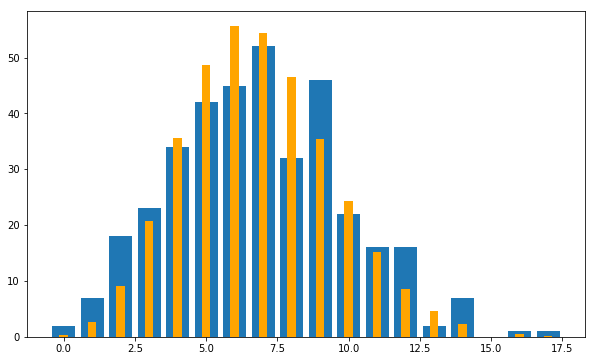

In [6]:
x, y = zip(*collections.Counter(events_by_day.values()).items())

fig, ax = plt.subplots(figsize=(10,6))
ax.bar(x,y)
mean = sum(xx*yy for xx,yy in zip(x,y)) / sum(y)

p = scipy.stats.poisson(mean)
ax.bar(x, p.pmf(x) * sum(y), 0.3, color="orange")
None

## Morning vs afternoon

In [7]:
dt = points.time_range[0].astype(datetime.datetime)
start = datetime.datetime(dt.year, dt.month, dt.day)
events_by_day = {}
while start < points.time_range[1]:
    end = start + datetime.timedelta(hours=12)
    count = np.sum((points.timestamps >= start) & (points.timestamps < end))
    events_by_day[start] = count
    start = end

<Container object of 11 artists>

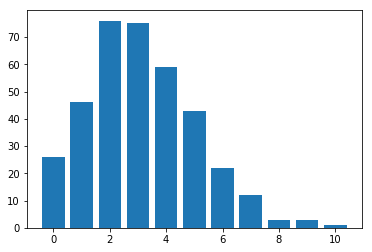

In [8]:
mornings = list(events_by_day.keys())[::2]
x, y = zip(*collections.Counter(events_by_day[m] for m in mornings).items())
plt.bar(x,y)

<Container object of 13 artists>

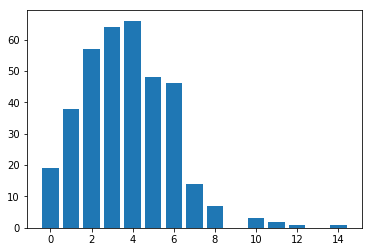

In [9]:
afternoons = list(events_by_day.keys())[1::2]
x, y = zip(*collections.Counter(events_by_day[m] for m in afternoons).items())
plt.bar(x,y)

# By day of week

In [10]:
dt = points.time_range[0].astype(datetime.datetime)
start = datetime.datetime(dt.year, dt.month, dt.day)
events_by_day = {}
while start < points.time_range[1]:
    end = start + datetime.timedelta(days=1)
    count = np.sum((points.timestamps >= start) & (points.timestamps < end))
    events_by_day[start] = count
    start = end

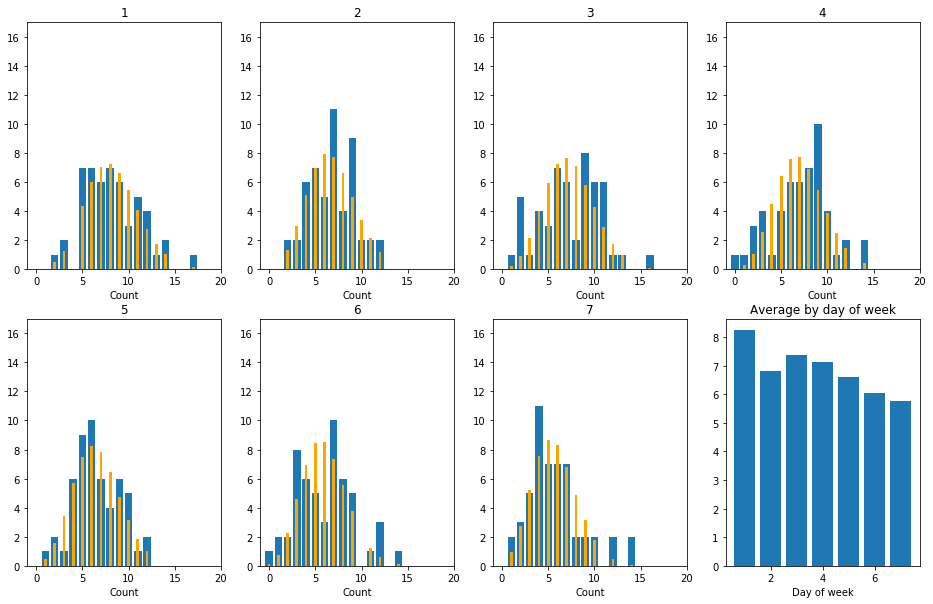

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16,10))

for ax, dow in zip(axes.flat, range(1,8)):
    ax.set_title(dow)
    c = collections.Counter(v for dt, v in events_by_day.items() if dt.isoweekday() == dow)
    x, y = zip(*c.items())
    mean = sum(xx*yy for xx,yy in zip(x,y)) / sum(y)
    
    # Sim data
    #data = np.random.poisson(mean, size=sum(y))
    #c = collections.Counter(data)
    #x, y = zip(*c.items())
    
    ax.bar(x, y)
    #assert max(x) <= 10
    #assert max(y) <= 17
    ax.set(xlim=[-1,20], ylim=[0,17], xlabel="Count")
    
    p = scipy.stats.poisson(mean)
    ax.bar(x, p.pmf(x) * sum(y), 0.3, color="orange")
    
ax = axes[1][3]
x = [1,2,3,4,5,6,7]
total_by_day_of_week = [ sum(v for dt, v in events_by_day.items() if dt.isoweekday() == dow) for dow in x ]
average_by_day_of_week = [ t / sum(1 for dt, v in events_by_day.items() if dt.isoweekday() == dow)
                          for dow, t in zip(x,total_by_day_of_week) ]
ax.bar(x, average_by_day_of_week)
ax.set(title="Average by day of week", xlabel="Day of week")
None

[(-4, 6.5)]

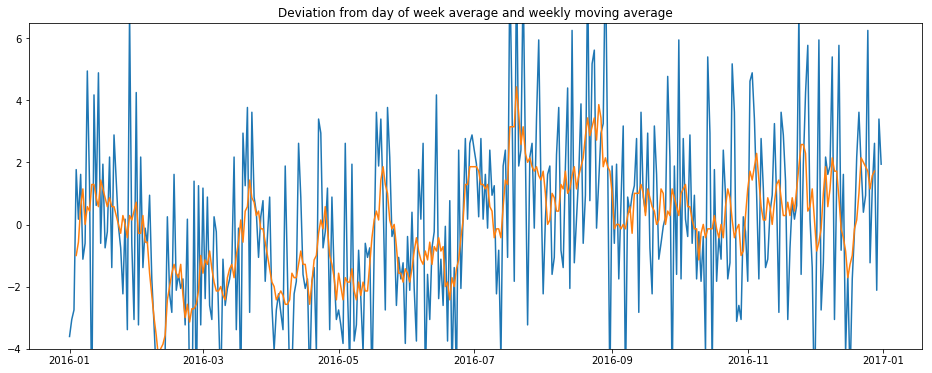

In [12]:
keys = list(events_by_day.keys())
keys.sort()
values = [events_by_day[k] - average_by_day_of_week[k.isoweekday()-1] for k in keys]

fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(keys, values)
ax.set_title("Deviation from day of week average and weekly moving average")

y = []
masize = 3
for i in range(masize, len(keys)-masize):
    y.append(sum( values[j] for j in range(i-masize, i+masize+1)) / (masize*2+1))
ax.plot(keys[masize:-masize], y)
ax.set(ylim=[-4, 6.5])

## Simulate from a Poisson process

[(-4, 6.5)]

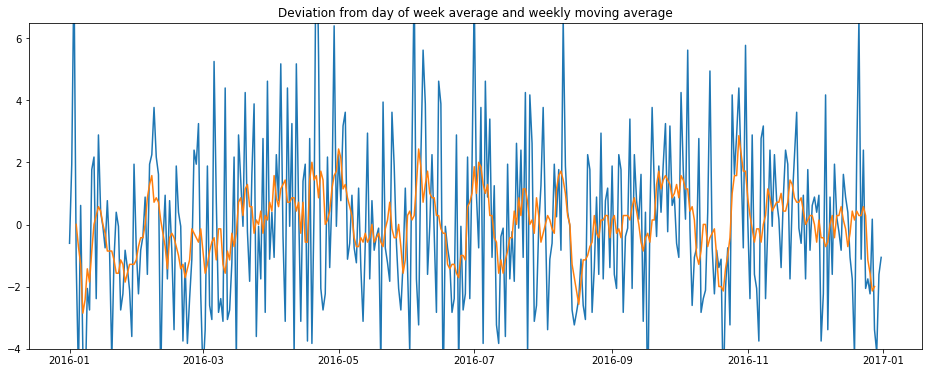

In [13]:
values = []
for k in keys:
    lam = average_by_day_of_week[k.isoweekday()-1]
    values.append(np.random.poisson(lam) - lam)
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(keys, values)
ax.set_title("Deviation from day of week average and weekly moving average")
y = []
masize = 3
for i in range(masize, len(keys)-masize):
    y.append(sum( values[j] for j in range(i-masize, i+masize+1)) / (masize*2+1))
ax.plot(keys[masize:-masize], y)
ax.set(ylim=[-4, 6.5])

# Time of day

Peak is at 8am--9am.  Do we think that's real, or more than people discover crimes at that time?

Bit inconclusive.  The crimes from 8am do seem to be very predominately from residential locations, so it could be discovery.  Or it could be a "start of shift" effect of crimes being logged then from overnight.  I don't know enough about how the data is collected to know for sure.

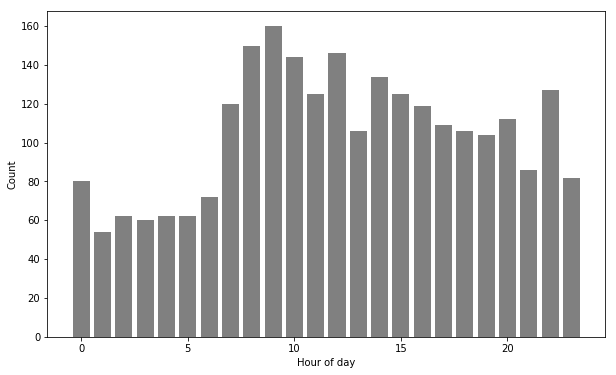

In [14]:
hours = [dt.hour for dt in points.timestamps.astype(datetime.datetime)]
hours = collections.Counter(hours)
x, y = zip(*hours.items())
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(x, y, color="grey")
ax.set(xlabel="Hour of day", ylabel="Count")

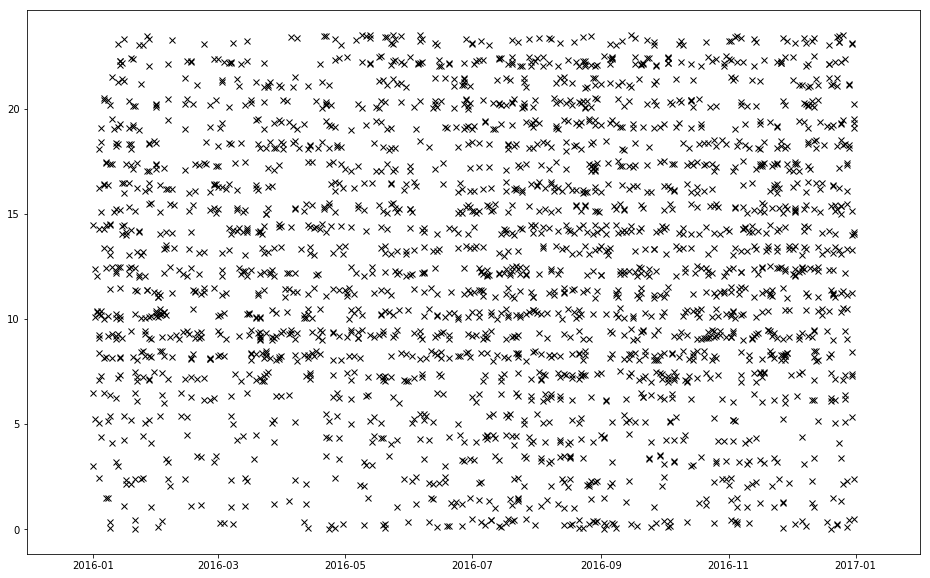

In [15]:
fig, ax = plt.subplots(figsize=(16,10))

y = [dt.hour for dt in points.timestamps.astype(datetime.datetime)]
x = [datetime.datetime(dt.year, dt.month, dt.day) for dt in points.timestamps.astype(datetime.datetime)]
y = np.asarray(y) + np.random.random(size=len(y)) * 0.5
ax.scatter(x,y, marker="x", color="black", linewidth=1)

# More detailed look

In [16]:
import impute.chicago

In [17]:
def gen():
    with lzma.open(os.path.join(datadir, "chicago_all.csv.xz"), "rt") as file:
        for row in impute.chicago.load_only_with_point(file):
            in_time_range = row.datetime >= study_start and row.datetime < study_end
            pt = shapely.geometry.Point(*proj(*row.point))
            if row.crime_type == "BURGLARY" and in_time_range and northside.intersects(pt):
                yield row
        
next(gen())

Row(id='10511676', crime_type='BURGLARY', crime_subtype='ATTEMPT FORCIBLE ENTRY', location='APARTMENT', address='052XX S JUSTINE ST', datetime=datetime.datetime(2016, 5, 5, 8, 20), point=(-87.663496806, 41.798797735))

In [18]:
all_rows = list(gen())

Not sure that the crime subtype tells us very much at all.

In [19]:
subtypes = set(r.crime_subtype for r in all_rows)
subtypes

{'ATTEMPT FORCIBLE ENTRY', 'FORCIBLE ENTRY', 'HOME INVASION', 'UNLAWFUL ENTRY'}

In [20]:
pd.DataFrame({
    h : {s:sum(row.crime_subtype==s and row.datetime.hour==h for row in all_rows) for s in subtypes}
    for h in range(24)
    }).T

,ATTEMPT FORCIBLE ENTRY,FORCIBLE ENTRY,HOME INVASION,UNLAWFUL ENTRY
0,1,50,1,28
1,2,35,1,16
2,2,48,1,11
3,1,44,0,15
4,1,36,1,24
5,1,47,0,14
6,4,46,0,22
7,7,85,2,26
8,8,88,4,50
9,7,111,4,38


In [21]:
set(r.location for r in all_rows)

{'ABANDONED BUILDING',
 'APARTMENT',
 'APPLIANCE STORE',
 'BAR OR TAVERN',
 'BARBERSHOP',
 'BOWLING ALLEY',
 'CHA APARTMENT',
 'CHURCH/SYNAGOGUE/PLACE OF WORSHIP',
 'CLEANING STORE',
 'COMMERCIAL / BUSINESS OFFICE',
 'CONSTRUCTION SITE',
 'CONVENIENCE STORE',
 'CURRENCY EXCHANGE',
 'DAY CARE CENTER',
 'DRUG STORE',
 'FACTORY/MANUFACTURING BUILDING',
 'GROCERY FOOD STORE',
 'HOTEL/MOTEL',
 'MEDICAL/DENTAL OFFICE',
 'OTHER',
 'OTHER RAILROAD PROP / TRAIN DEPOT',
 'PARK PROPERTY',
 'PARKING LOT/GARAGE(NON.RESID.)',
 'POOL ROOM',
 'RESIDENCE',
 'RESIDENCE PORCH/HALLWAY',
 'RESIDENCE-GARAGE',
 'RESIDENTIAL YARD (FRONT/BACK)',
 'RESTAURANT',
 'SCHOOL, PRIVATE, BUILDING',
 'SCHOOL, PUBLIC, BUILDING',
 'SCHOOL, PUBLIC, GROUNDS',
 'SIDEWALK',
 'SMALL RETAIL STORE',
 'STREET',
 'VACANT LOT/LAND',
 'VEHICLE NON-COMMERCIAL',
 'VEHICLE-COMMERCIAL',
 'WAREHOUSE'}

In [22]:
c = collections.Counter(r.location for r in all_rows if r.datetime.hour==8)
total = sum(c.values())
c.values()
c = {k:100*v/total for k, v in c.items()}
c

{'ABANDONED BUILDING': 0.6666666666666666,
 'APARTMENT': 28.666666666666668,
 'OTHER': 1.3333333333333333,
 'OTHER RAILROAD PROP / TRAIN DEPOT': 0.6666666666666666,
 'RESIDENCE': 43.333333333333336,
 'RESIDENCE-GARAGE': 22.666666666666668,
 'SMALL RETAIL STORE': 0.6666666666666666,
 'VACANT LOT/LAND': 2.0}

In [23]:
locs = collections.Counter(r.location for r in all_rows)
locations = collections.defaultdict(int)
for key, count in locs.items():
    if count < 10:
        locations["OTHER"] += count
    else:
        locations[key] += count
total = sum(locations.values())
locations = {k:100*v/total for k, v in locations.items()}
locations

{'ABANDONED BUILDING': 0.7578779417630634,
 'APARTMENT': 22.816114878340645,
 'CHURCH/SYNAGOGUE/PLACE OF WORSHIP': 0.3988831272437176,
 'COMMERCIAL / BUSINESS OFFICE': 0.43877143996808937,
 'OTHER': 6.102911846828879,
 'RESIDENCE': 40.007977662544874,
 'RESIDENCE-GARAGE': 23.09533306741125,
 'RESTAURANT': 2.5927403270841642,
 'SCHOOL, PUBLIC, BUILDING': 0.43877143996808937,
 'SMALL RETAIL STORE': 1.475867570801755,
 'VACANT LOT/LAND': 1.8747506980454727}

# Plot for article

In [24]:
study_start = datetime.datetime(2016,1,1)
study_end = datetime.datetime(2017,1,1)

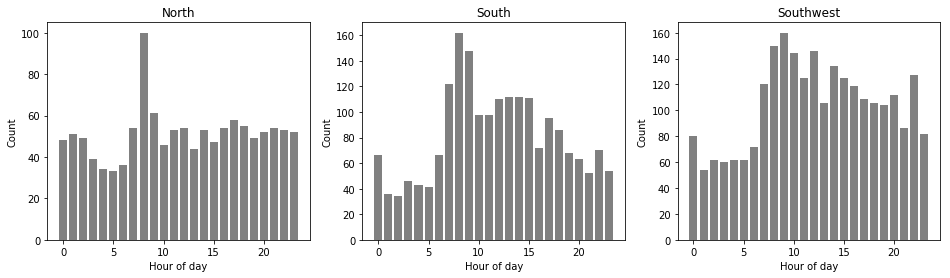

In [25]:
fig, axes = plt.subplots(ncols=3, figsize=(16,4))

for ax, side in zip(axes, ["North", "South", "Southwest"]):
    mask = (all_points.timestamps >= study_start) & (all_points.timestamps < study_end)
    points = all_points[mask]
    geo = open_cp.sources.chicago.get_side(side)
    points = open_cp.geometry.intersect_timed_points(points, geo)

    hours = [dt.hour for dt in points.timestamps.astype(datetime.datetime)]
    hours = collections.Counter(hours)
    x, y = zip(*hours.items())
    ax.bar(x, y, color="grey")
    ax.set(xlabel="Hour of day", ylabel="Count", title=side)

In [26]:
fig.savefig("../events_by_hour.pdf")